# Load Data
Decided to just grab all the data in this one and manually manipulate it for binary features


In [1]:
import pybaseball as pb

pitch_data = pb.statcast("2025-01-01", "2025-9-30")
filename = f"statcast_all_cols_2025.csv"
pitch_data.to_csv(filename, index=False)
print(f"Data saved to {filename}")

This is a large query, it may take a moment to complete


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 1/200 [00:00<00:35,  5.62it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 2/200 [00:01<03:33,  1.08s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 3/200 [00:02<02:54,  1.13it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pybaseb

Data saved to statcast_all_cols_2025.csv


In [2]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('statcast_all_cols_2025.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

Dataset shape: (755179, 118)

Column names:
['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom',

# Filter Columns Function
Create a function to keep only the relevant columns

In [3]:
def add_pitch_type_one_hot(dataframe, pitch_type_column='pitch_type'):
    """
    Add one-hot encoded columns for each unique pitch type.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        pitch_type_column (str): Name of the column containing pitch types. Default is 'pitch_type'.
    
    Returns:
        pd.DataFrame: A new DataFrame with one-hot encoded pitch type columns added.
    """
    df_with_features = dataframe.copy()
    
    # Get unique pitch types (excluding NaN values)
    unique_pitch_types = df_with_features[pitch_type_column].dropna().unique()
    print(f"Found {len(unique_pitch_types)} unique pitch types: {sorted(unique_pitch_types)}")
    
    # Create one-hot encoded columns for each pitch type
    for pitch_type in unique_pitch_types:
        column_name = f"pitch_type_{pitch_type}"
        df_with_features[column_name] = (df_with_features[pitch_type_column] == pitch_type).astype(int)
    
    print(f"Added {len(unique_pitch_types)} one-hot encoded columns for pitch types")
    
    return df_with_features

In [4]:
def add_count_one_hot(dataframe, balls_column='balls', strikes_column='strikes'):
    """
    Add one-hot encoded columns for each unique ball-strike count.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        balls_column (str): Name of the column containing ball counts. Default is 'balls'.
        strikes_column (str): Name of the column containing strike counts. Default is 'strikes'.
    
    Returns:
        pd.DataFrame: A new DataFrame with one-hot encoded count columns added.
    """
    df_with_features = dataframe.copy()
    
    
    # Create a combined count column (e.g., "0-0", "1-2", "3-2")
    df_with_features['count'] = df_with_features[balls_column].astype(str) + '-' + df_with_features[strikes_column].astype(str)
    
    # Get unique counts (excluding NaN values)
    unique_counts = df_with_features['count'].dropna().unique()
    print(f"Found {len(unique_counts)} unique counts: {sorted(unique_counts)}")
    
    # Create one-hot encoded columns for each count
    for count in unique_counts:
        column_name = f"count_{count}"
        df_with_features[column_name] = (df_with_features['count'] == count).astype(int)
    
    print(f"Added {len(unique_counts)} one-hot encoded columns for counts")
    
    # Drop the temporary 'count' column
    df_with_features = df_with_features.drop('count', axis=1)
    
    return df_with_features

In [5]:
def add_handedness_one_hot(dataframe, batter_column='stand', pitcher_column='p_throws'):
    """
    Add one-hot encoded columns for batter and pitcher handedness.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        batter_column (str): Name of the column containing batter handedness. Default is 'stand'.
        pitcher_column (str): Name of the column containing pitcher handedness. Default is 'p_throws'.
    
    Returns:
        pd.DataFrame: A new DataFrame with one-hot encoded handedness columns added.
    """
    df_with_features = dataframe.copy()
    
    # Create one-hot encoded columns for batter handedness
    df_with_features['batter_hand_L'] = (df_with_features[batter_column] == 'L').astype(int)
    df_with_features['batter_hand_R'] = (df_with_features[batter_column] == 'R').astype(int)
    print(f"Added one-hot encoded columns for batter handedness: batter_hand_L, batter_hand_R")


    # Create one-hot encoded columns for pitcher handedness
    df_with_features['pitcher_hand_L'] = (df_with_features[pitcher_column] == 'L').astype(int)
    df_with_features['pitcher_hand_R'] = (df_with_features[pitcher_column] == 'R').astype(int)
    print(f"Added one-hot encoded columns for pitcher handedness: pitcher_hand_L, pitcher_hand_R")
    
    return df_with_features


# Apply all feature engineering functions
df_with_features = add_pitch_type_one_hot(df)
df_with_features = add_count_one_hot(df_with_features)
df_with_features = add_handedness_one_hot(df_with_features)

# Display the new columns
print("\nPitch type columns:")
pitch_type_columns = [col for col in df_with_features.columns if col.startswith('pitch_type_')]
print(pitch_type_columns)

print("\nCount columns:")
count_columns = [col for col in df_with_features.columns if col.startswith('count_')]
print(count_columns)

print("\nHandedness columns:")
handedness_columns = [col for col in df_with_features.columns if 'hand' in col.lower()]
print(handedness_columns)

# Show a sample of the data with the new features
print("\nSample data with one-hot encoded features:")
display_cols = ['player_name', 'pitch_type', 'stand', 'p_throws'] + pitch_type_columns[:2] + count_columns[:2] + handedness_columns
df_with_features[display_cols].head(10)

Found 17 unique pitch types: ['CH', 'CS', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'ST', 'SV']
Added 17 one-hot encoded columns for pitch types
Found 16 unique counts: ['0-0', '0-1', '0-2', '0-3', '1-0', '1-1', '1-2', '1-3', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2', '4-2', '4-3']
Added 16 one-hot encoded columns for counts
Added one-hot encoded columns for batter handedness: batter_hand_L, batter_hand_R
Added one-hot encoded columns for pitcher handedness: pitcher_hand_L, pitcher_hand_R

Pitch type columns:
['pitch_type_FF', 'pitch_type_SL', 'pitch_type_FS', 'pitch_type_SI', 'pitch_type_CU', 'pitch_type_ST', 'pitch_type_FC', 'pitch_type_CH', 'pitch_type_KC', 'pitch_type_SV', 'pitch_type_KN', 'pitch_type_PO', 'pitch_type_FA', 'pitch_type_EP', 'pitch_type_CS', 'pitch_type_SC', 'pitch_type_FO']

Count columns:
['count_2-2', 'count_2-1', 'count_1-1', 'count_1-0', 'count_0-0', 'count_0-2', 'count_0-1', 'count_1-2', 'count_3-2', 'count_3-0', 'count_2-0', 

,player_name,pitch_type,stand,p_throws,pitch_type_FF,pitch_type_SL,count_2-2,count_2-1,batter_hand_L,batter_hand_R,pitcher_hand_L,pitcher_hand_R
0,"Chapman, Aroldis",FF,L,L,1,0,1,0,1,0,1,0
1,"Chapman, Aroldis",SL,L,L,0,1,0,1,1,0,1,0
2,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
3,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
4,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
5,"Chapman, Aroldis",SL,L,L,0,1,0,0,1,0,1,0
6,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
7,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
8,"Chapman, Aroldis",FF,L,L,1,0,0,0,1,0,1,0
9,"Chapman, Aroldis",FS,R,L,0,0,0,0,0,1,1,0


# Feature Engineering
Add one-hot encoded features for pitch types

In [6]:
def filter_columns(dataframe, columns_to_keep, min_pitch_count=None, pitcher_column='player_name'):
    """
    Filter a DataFrame to keep only the specified columns and optionally filter by minimum pitch count.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        columns_to_keep (list): List of column names to keep.
        min_pitch_count (int, optional): Minimum number of pitches a pitcher must have thrown to be included.
        pitcher_column (str): Name of the column containing pitcher names. Default is 'player_name'.
    
    Returns:
        pd.DataFrame: A new DataFrame with only the specified columns and filtered by pitch count.
    """
    # Check which columns exist in the dataframe
    available_columns = [col for col in columns_to_keep if col in dataframe.columns]
    missing_columns = [col for col in columns_to_keep if col not in dataframe.columns]
    
    if missing_columns:
        print(f"Warning: The following columns were not found: {missing_columns}")
    
    # Filter by columns first
    df_filtered = dataframe[available_columns].copy()
    
    # Apply minimum pitch count filter if specified
    if min_pitch_count is not None and pitcher_column in df_filtered.columns:
        pitch_counts = df_filtered[pitcher_column].value_counts()
        pitchers_to_keep = pitch_counts[pitch_counts >= min_pitch_count].index
        
        original_count = len(df_filtered)
        df_filtered = df_filtered[df_filtered[pitcher_column].isin(pitchers_to_keep)]
        
        print(f"Filtered out {len(pitch_counts) - len(pitchers_to_keep)} pitchers with fewer than {min_pitch_count} pitches")
        print(f"Removed {original_count - len(df_filtered)} rows")
        print(f"Remaining pitchers: {len(pitchers_to_keep)}")
    
    return df_filtered


# Change this based on what we're doing
columns_to_keep = [
    'player_name',
    'release_speed',
    'release_pos_x',
    'release_pos_z',
    'pfx_x',
    'pfx_z',
    'plate_x',
    'plate_z',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'release_spin',
    'spin_axis',
]

# Add all one-hot encoded pitch type columns to the list
pitch_type_one_hot_cols = [col for col in df_with_features.columns if col.startswith('pitch_type_')]
columns_to_keep.extend(pitch_type_one_hot_cols)

# Add all one-hot encoded count columns to the list
count_one_hot_cols = [col for col in df_with_features.columns if col.startswith('count_')]
columns_to_keep.extend(count_one_hot_cols)

# Add all one-hot encoded handedness columns to the list
handedness_cols = [col for col in df_with_features.columns if 'hand' in col.lower()]
columns_to_keep.extend(handedness_cols)

# Apply the filter function with minimum pitch count
df_filtered = filter_columns(df_with_features, columns_to_keep, min_pitch_count=2000)

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"\nFiltered columns:")
print(df_filtered.columns.tolist())
df_filtered.head()

Filtered out 1091 pitchers with fewer than 2000 pitches
Removed 461994 rows
Remaining pitchers: 110

Filtered dataset shape: (293185, 52)

Filtered columns:
['player_name', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'spin_axis', 'pitch_type_FF', 'pitch_type_SL', 'pitch_type_FS', 'pitch_type_SI', 'pitch_type_CU', 'pitch_type_ST', 'pitch_type_FC', 'pitch_type_CH', 'pitch_type_KC', 'pitch_type_SV', 'pitch_type_KN', 'pitch_type_PO', 'pitch_type_FA', 'pitch_type_EP', 'pitch_type_CS', 'pitch_type_SC', 'pitch_type_FO', 'count_2-2', 'count_2-1', 'count_1-1', 'count_1-0', 'count_0-0', 'count_0-2', 'count_0-1', 'count_1-2', 'count_3-2', 'count_3-0', 'count_2-0', 'count_3-1', 'count_4-2', 'count_4-3', 'count_0-3', 'count_1-3', 'batter_hand_L', 'batter_hand_R', 'pitcher_hand_L', 'pitcher_hand_R']


,player_name,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,...,count_2-0,count_3-1,count_4-2,count_4-3,count_0-3,count_1-3,batter_hand_L,batter_hand_R,pitcher_hand_L,pitcher_hand_R
43,"Crochet, Garrett",100.2,2.41,5.92,1.26,0.85,0.47,1.84,-8.498561,-145.455655,...,0,0,0,0,0,0,1,0,1,0
44,"Crochet, Garrett",97.3,2.49,6.10,0.58,1.21,1.69,4.42,-3.538441,-141.573377,...,0,0,0,0,0,0,1,0,1,0
45,"Crochet, Garrett",98.6,2.20,6.06,0.97,0.82,-0.79,2.64,-10.583974,-143.139599,...,0,0,0,0,0,0,1,0,1,0
46,"Crochet, Garrett",85.3,1.98,6.29,-1.21,-0.29,-0.47,2.72,-3.378757,-124.239066,...,0,0,0,0,0,0,1,0,1,0
47,"Crochet, Garrett",98.0,2.14,6.12,0.41,1.21,-0.65,4.39,-8.620733,-142.533048,...,0,0,0,0,0,0,1,0,1,0


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# set up MLP for pitcher classification
class PitcherClassifier(nn.Module):
    """A simple feedforward neural network for pitcher classification.
    2 layers with ReLU activations and dropout for regularization.
    Args:
        num_features (int): Number of input features.
        num_pitchers (int): Number of unique pitchers (output classes).
        hidden1 (int): Number of neurons in the first hidden layer.
        hidden2 (int): Number of neurons in the second hidden layer.
        dropout_rate (float): Dropout rate for regularization.
    """
    def __init__(self, num_features, num_pitchers, hidden1=128, hidden2=64, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden2, num_pitchers)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)
    

Here we train the MLP. Current accuracy is like .83 with 50 epochs. Haven't evaluated it on other metrics yet.

In [9]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Prepare the data
df_filtered = df_filtered.dropna()

# Encode pitcher names as labels
le = LabelEncoder()
y = le.fit_transform(df_filtered['player_name'])

# Drop the player_name column to get features only
X = df_filtered.drop(columns=['player_name'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=64, shuffle=False)

# Initialize model, optimizer, and loss function
model = PitcherClassifier(num_features=X_train.shape[1], num_pitchers=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Lists to track metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(50):
    # Training
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_dl)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_dl:
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            epoch_val_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    
    # Calculate average validation loss and accuracy
    avg_val_loss = epoch_val_loss / len(val_dl)
    val_acc = correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

print(f"\nFinal validation accuracy: {val_accuracies[-1]:.4f}")


Epoch 1: Train Loss = 1.8457, Val Loss = 1.0382, Val Acc = 0.6818
Epoch 2: Train Loss = 1.1768, Val Loss = 0.8630, Val Acc = 0.7299
Epoch 3: Train Loss = 1.0564, Val Loss = 0.7782, Val Acc = 0.7524
Epoch 4: Train Loss = 0.9841, Val Loss = 0.7180, Val Acc = 0.7707
Epoch 5: Train Loss = 0.9400, Val Loss = 0.6862, Val Acc = 0.7819
Epoch 6: Train Loss = 0.9042, Val Loss = 0.6601, Val Acc = 0.7881
Epoch 7: Train Loss = 0.8783, Val Loss = 0.6390, Val Acc = 0.7954
Epoch 8: Train Loss = 0.8582, Val Loss = 0.6268, Val Acc = 0.7972
Epoch 9: Train Loss = 0.8398, Val Loss = 0.6102, Val Acc = 0.8040
Epoch 10: Train Loss = 0.8236, Val Loss = 0.6114, Val Acc = 0.8024
Epoch 11: Train Loss = 0.8142, Val Loss = 0.5960, Val Acc = 0.8083
Epoch 12: Train Loss = 0.8036, Val Loss = 0.5925, Val Acc = 0.8076
Epoch 13: Train Loss = 0.7922, Val Loss = 0.5816, Val Acc = 0.8121
Epoch 14: Train Loss = 0.7875, Val Loss = 0.5796, Val Acc = 0.8126
Epoch 15: Train Loss = 0.7789, Val Loss = 0.5689, Val Acc = 0.8166
Epoc

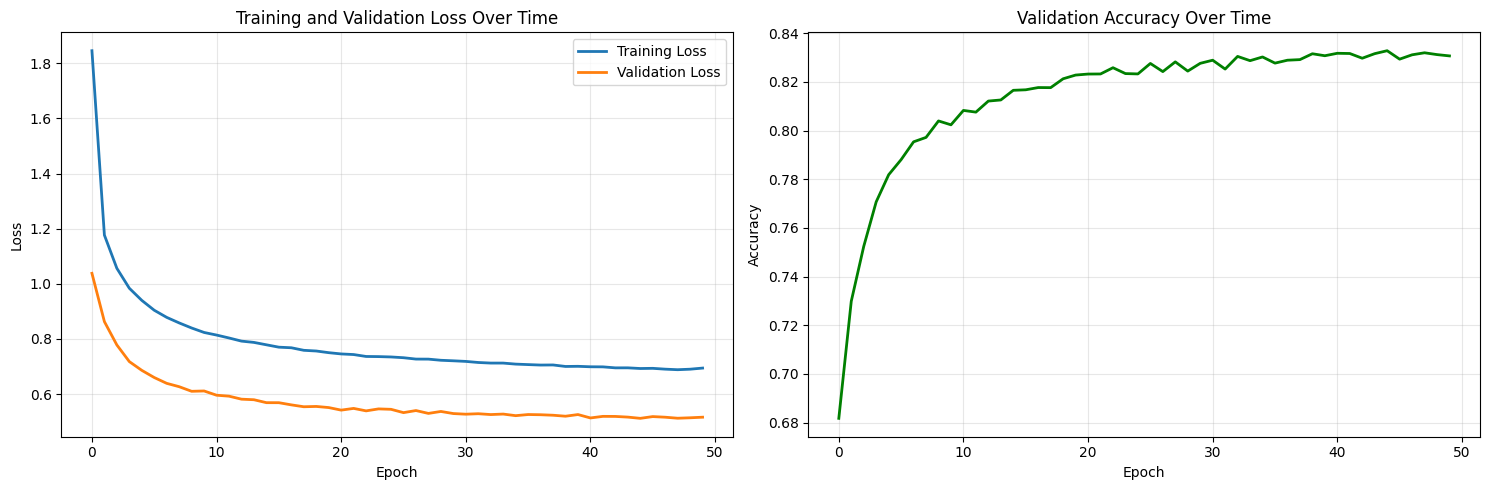

Top-1 Accuracy (Exact Match): 0.8307
Top-3 Accuracy: 0.9607
Top-5 Accuracy: 0.9847

Per-pitcher performance (sample):
  Abbott, Andrew: 0.810 accuracy (554 pitches)
  Alcantara, Sandy: 0.889 accuracy (578 pitches)
  Allen, Logan: 0.970 accuracy (527 pitches)
  Anderson, Tyler: 0.957 accuracy (468 pitches)
  Bassitt, Chris: 0.702 accuracy (600 pitches)
  Baz, Shane: 0.717 accuracy (540 pitches)
  Bello, Brayan: 0.905 accuracy (528 pitches)
  Berríos, José: 0.761 accuracy (548 pitches)
  Bibee, Tanner: 0.780 accuracy (623 pitches)
  Boyd, Matthew: 0.968 accuracy (561 pitches)
  Bradley, Taj: 0.758 accuracy (475 pitches)
  Brown, Hunter: 0.736 accuracy (592 pitches)
  Bubic, Kris: 0.837 accuracy (404 pitches)
  Buehler, Walker: 0.789 accuracy (451 pitches)
  Burke, Sean: 0.860 accuracy (506 pitches)
  Cabrera, Edward: 0.782 accuracy (450 pitches)
  Cameron, Noah: 0.781 accuracy (433 pitches)
  Castillo, Luis: 0.842 accuracy (614 pitches)
  Cease, Dylan: 0.870 accuracy (623 pitches)
  Cecc

In [10]:
# Visualize training progress
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot validation accuracy
ax2.plot(val_accuracies, color='green', linewidth=2)
ax2.set_title('Validation Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate on validation set with more metrics
from sklearn.metrics import top_k_accuracy_score

model.eval()
with torch.no_grad():
    val_logits = model(X_val)
    val_preds = val_logits.argmax(dim=1).numpy()
    val_probs = F.softmax(val_logits, dim=1).numpy()

# Top-k accuracy (how often the correct pitcher is in top k predictions)
top3_acc = top_k_accuracy_score(y_val.numpy(), val_probs, k=3)
top5_acc = top_k_accuracy_score(y_val.numpy(), val_probs, k=5)

print(f"Top-1 Accuracy (Exact Match): {val_accuracies[-1]:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

# Show performance for a few example pitchers
print("\nPer-pitcher performance (sample):")
unique_pitchers = np.unique(y_val.numpy())  # All pitchers
for pitcher_id in unique_pitchers:
    pitcher_name = le.inverse_transform([pitcher_id])[0]
    pitcher_mask = y_val.numpy() == pitcher_id
    pitcher_acc = (val_preds[pitcher_mask] == pitcher_id).mean()
    pitcher_count = pitcher_mask.sum()
    print(f"  {pitcher_name}: {pitcher_acc:.3f} accuracy ({pitcher_count} pitches)")

We saved the output above in a file titled 'accuracies.txt'. Examining the accuracies outputted, we notice that the model can't seem to generate good accuracy on a few pitchers. Let's clean up this output a bit so we can see which ones.

In [112]:
import numpy as np
# Here, we will examine what pitchers our model isn't good at classifying.
# I've copied a sample of the output from the feature cleaning notebook so we can take a look.

fname = f"accuracies.txt"
tup = []


with open(fname, 'r') as file:
    for line in file:
        zero_idx = line[(line.index('.')-1):(line.index('.')+4)]
        names_idx = line[:line.index(':')]
        pitch_count_idx = line[(line.index('(')+1):(line.index('(')+4)]
        tup.append((names_idx, float(zero_idx), float(pitch_count_idx)))


# We sort the compiled list by model accuracy, and print the 3 lowest accuracies our model generated
# alongside the name of the player it couldn't accurately guess.
tup = sorted(tup, key = lambda x: x[1])
tupnp = np.array(tup)
print(tupnp[0], tupnp[1], tupnp[2])
print()

# These players are :
#   Shane Smith (accuracy 33.7%)
#   Randy Vasquez (accuracy 43%)
#   Michael Lorenzen (accuracy 44.4%)
# If you notice they all have generally lower pitch counts, but just to be sure
# we'll sort all of them by pitch count and look again

tup = sorted(tup, key = lambda x: x[2])
tupnp = np.array(tup)
print(tupnp[0], tupnp[1], tupnp[2])
print()

# These players are :
#   Jack Kochanowicz (387 pitches, accuracy 64.9%)
#   Simeon Woods Richardson (391 pitches, accuracy 75.2%)
#   Cade Povich (394 pitches, accuracy 81%)
# All of these guys have significantly higher accuracies than the lowest three while their pitch counts are significantly lower.
# So clearly there are other pretty significant factors here.

# Next I attempt to see if there's a correlation between low pitches thrown and low accuracy:

bottom20_acc = tupnp[:, 1][:20].astype(float)
avg= np.sum(bottom20_acc)/len(bottom20_acc)
print("Average accuracy of 20 lowest-pitched pitchers: ", avg)
print()
# Average accuracy was about 80.5%

bottom50_acc = tupnp[:, 1][:50].astype(float)
avg= np.sum(bottom50_acc)/len(bottom50_acc)
print("Average accuracy of 50 lowest-pitched pitchers: ", avg)
print()
# Average accuracy was about 79.1%

mid30_acc = tupnp[:, 1][50:81].astype(float)
avg= np.sum(mid30_acc)/len(mid30_acc)
print("Average accuracy of 50th lowest-pitched pitcher to 80th lowest-pitched: ", avg)
print()
# Average accuracy was about 85.5%

top50_acc = tupnp[:, 1][50:].astype(float)
avg= np.sum(top50_acc)/len(top50_acc)
print("Average accuracy of 50th lowest-pitched pitcher to highest-pitched: ", avg)
print()
# Average accuracy was about 86.6%

# So a bit of increase as we get more pitch data, but nothing crazy. It isn't the entire reason
# why our pitchers cannot be accurately classified. We will need to examine other features.


['Smith, Shane' '0.337' '475.0'] ['Vásquez, Randy' '0.43' '430.0'] ['Lorenzen, Michael' '0.444' '491.0']

['Kochanowicz, Jack' '0.649' '387.0'] ['Woods Richardson, Simeon' '0.752' '391.0'] ['Povich, Cade' '0.81' '394.0']

Average accuracy of 20 lowest-pitched pitchers:  0.8056000000000001

Average accuracy of 50 lowest-pitched pitchers:  0.79098

Average accuracy of 50th lowest-pitched pitcher to 80th lowest-pitched:  0.8541935483870967

Average accuracy of 50th lowest-pitched pitcher to highest-pitched:  0.8658833333333332



In [138]:
# Force Python to reload the module
import importlib
import sys

# Remove the module if it's already loaded
if 'shap_baseball_toolkit' in sys.modules:
    del sys.modules['shap_baseball_toolkit']

# Now import fresh
from shap_baseball_toolkit import run_shap_analysis, inspect_player
from joblib import load
import pandas as pd

print("Successfully imported shap_baseball_toolkit")

Successfully imported shap_baseball_toolkit


# Deep Analysis of Model Performance and Feature Importance

We'll perform a detailed analysis of our pitcher classification model focusing on:

1. Performance Analysis
   - Identify best and worst performing pitchers
   - Calculate per-pitcher accuracy and sample counts
   - Analyze confusion patterns for poor performers

2. SHAP Analysis
   - Use gradient-based explanations for efficiency
   - Focus on representative examples from each selected pitcher
   - Analyze global and per-pitcher feature importance

3. Visualization
   - Generate feature importance heatmaps
   - Create per-pitcher feature importance bar charts
   - Visualize confusion patterns

In [139]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Create output directory
os.makedirs('outputs', exist_ok=True)

# Set model to evaluation mode
model.eval()

# Get predictions and losses for all test samples
with torch.no_grad():
    logits = model(X_val)
    probs = F.softmax(logits, dim=1)
    preds = logits.argmax(dim=1)
    losses = F.cross_entropy(logits, y_val, reduction='none')

# Convert to numpy for analysis
preds_np = preds.numpy()
y_test_np = y_val.numpy()
losses_np = losses.numpy()

# Calculate per-pitcher metrics
pitcher_metrics = []
for pitcher_id in np.unique(y_test_np):
    mask = y_test_np == pitcher_id
    n_samples = mask.sum()
    accuracy = (preds_np[mask] == y_test_np[mask]).mean()
    avg_loss = losses_np[mask].mean()
    worst_loss_idx = mask.nonzero()[0][losses_np[mask].argmax()]
    confusion_targets = preds_np[mask][preds_np[mask] != pitcher_id]
    
    pitcher_metrics.append({
        'pitcher_id': pitcher_id,
        'name': le.inverse_transform([pitcher_id])[0],
        'n_samples': n_samples,
        'accuracy': accuracy,
        'avg_loss': avg_loss,
        'worst_loss_idx': worst_loss_idx,
        'confusion_targets': confusion_targets
    })

# Convert to DataFrame and sort by accuracy
metrics_df = pd.DataFrame(pitcher_metrics)
metrics_df = metrics_df.sort_values('accuracy')

# Get worst and best 3 pitchers
worst_3 = metrics_df.head(3)
best_3 = metrics_df.tail(3)

print("Worst Performing Pitchers:")
print(worst_3[['name', 'accuracy', 'n_samples', 'avg_loss']].to_string())
print("\nBest Performing Pitchers:")
print(best_3[['name', 'accuracy', 'n_samples', 'avg_loss']].to_string())

# Enhanced confusion analysis for worst performers
print("\nDetailed Confusion Analysis for Worst Performers:")
for _, row in worst_3.iterrows():
    confusion_counts = Counter(row['confusion_targets'])
    most_common = confusion_counts.most_common(7)  # Get top 7 misclassifications
    print(f"\n{row['name']} ({row['n_samples']} total samples):")
    correct_samples = int(row['accuracy'] * row['n_samples'])
    incorrect_samples = row['n_samples'] - correct_samples
    print(f"  Correctly classified: {correct_samples} samples ({row['accuracy']:.1%})")
    print(f"  Incorrectly classified: {incorrect_samples} samples ({1-row['accuracy']:.1%})")
    print(f"  Top misclassifications:")
    total_shown = 0
    for target_id, count in most_common:
        target_name = le.inverse_transform([target_id])[0]
        percentage = count / incorrect_samples * 100
        print(f"    - {target_name}: {count} times ({percentage:.1f}% of errors)")
        total_shown += count
    remaining = incorrect_samples - total_shown
    if remaining > 0:
        print(f"    - Others: {remaining} times ({remaining/incorrect_samples*100:.1f}% of errors)")

Worst Performing Pitchers:
                 name  accuracy  n_samples  avg_loss
89       Smith, Shane  0.349474        475  1.735685
51  Lorenzen, Michael  0.443992        491  1.655686
99     Vásquez, Randy  0.465116        430  1.464768

Best Performing Pitchers:
               name  accuracy  n_samples      avg_loss
35  Hendricks, Kyle  0.996117        515  1.979996e-02
49     Lodolo, Nick  1.000000        510  5.401701e-07
83        Sears, JP  1.000000        500  1.527236e-04

Detailed Confusion Analysis for Worst Performers:

Smith, Shane (475 total samples):
  Correctly classified: 166 samples (34.9%)
  Incorrectly classified: 309 samples (65.1%)
  Top misclassifications:
    - Martin, Davis: 39 times (12.6% of errors)
    - Kirby, George: 28 times (9.1% of errors)
    - Senzatela, Antonio: 23 times (7.4% of errors)
    - Leiter, Jack: 22 times (7.1% of errors)
    - Holmes, Grant: 22 times (7.1% of errors)
    - Severino, Luis: 14 times (4.5% of errors)
    - Mize, Casey: 12 ti

In [148]:
# ===== SHAP on 20 CORRECT pitches per selected pitcher (aggregate per pitcher) =====
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re

# ---------- helpers ----------


def to_df(X_like, cols=None):
    if isinstance(X_like, pd.DataFrame):
        return X_like.copy()
    if isinstance(X_like, torch.Tensor):
        arr = X_like.detach().cpu().numpy()
    else:
        arr = np.asarray(X_like)
    if cols is None:
        cols = [f"f_{i}" for i in range(arr.shape[1])]
    return pd.DataFrame(arr, columns=cols)


def safe(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', str(s))


os.makedirs("outputs/per_player_plots", exist_ok=True)
os.makedirs("outputs/per_player_plots_signed", exist_ok=True)

# ---------- 1) Build DataFrames and predictions on full val ----------
feature_names = list(X.columns) if 'X' in globals() and isinstance(
    X, pd.DataFrame) else [f"f_{i}" for i in range(X_val.shape[1])]
X_train_df = to_df(X_train, cols=feature_names)
X_val_df = to_df(X_val,   cols=feature_names)

y_test_np = (y_val.detach().cpu().numpy() if isinstance(
    y_val, torch.Tensor) else np.asarray(y_val)).astype(int)
player_ids_full = le.inverse_transform(y_test_np)

with torch.no_grad():
    logits_full = model(torch.tensor(X_val_df.values, dtype=torch.float32))
    probs_full = F.softmax(logits_full, dim=1).cpu().numpy()
    preds_full = logits_full.argmax(dim=1).cpu().numpy()

# ---------- 2) Reuse your worst_3 / best_3 selection ----------
# (If you don't already have these in scope, re-run your metrics_df computation block beforehand.)
selected_names = worst_3["name"].tolist() + best_3["name"].tolist()
selected_class_idx = [int(le.transform([n])[0]) for n in selected_names]

# ---------- 3) For each pitcher, collect up to K CORRECT rows ----------
K = 20
rng = np.random.default_rng(42)

rows_per_pitcher = {}
selected_rows = []
selected_names_per_row = []

for name, cls in zip(selected_names, selected_class_idx):
    correct_idx = np.where((y_test_np == cls) & (preds_full == cls))[0]
    if correct_idx.size == 0:
        print(f"[warn] No correct rows for {name}; skipping.")
        rows_per_pitcher[name] = []
        continue
    take = min(K, correct_idx.size)
    chosen = rng.choice(correct_idx, size=take, replace=False)
    rows_per_pitcher[name] = chosen.tolist()
    selected_rows.extend(chosen.tolist())
    selected_names_per_row.extend([name] * take)

selected_rows = np.array(selected_rows, dtype=int)
if selected_rows.size == 0:
    raise RuntimeError(
        "No correct rows found for the 6 pitchers — cannot run aggregated SHAP.")

# Build the small test slice we will explain
X_selected_df = X_val_df.iloc[selected_rows].reset_index(drop=True)
y_selected = y_test_np[selected_rows]
# aligns 1:1 with X_selected_df rows
player_ids_sel = np.array(selected_names_per_row)

# ---------- 4) Small background from train ----------
bg_n = min(64, len(X_train_df))
bg_idx = rng.choice(len(X_train_df), size=bg_n, replace=False)
X_background_df = X_train_df.iloc[bg_idx].reset_index(drop=True)

# ---------- 5) Run your SHAP wrapper once on this combined set ----------
artifacts = run_shap_analysis(
    model=model,
    X_train=X_background_df,    # background (small)
    X_test=X_selected_df,       # all selected rows across the 6 pitchers
    y_test=y_selected,          # int labels for those rows
    feature_names=feature_names,
    player_ids=player_ids_sel
)
print("SHAP computed for", len(X_selected_df), "rows.")

# ---------- 6) Normalize SHAP container to (N,F) per-row matrix for the row’s TRUE class ----------
sv = artifacts["shap_values_list"]
N, F = X_selected_df.shape


def shap_for_class_matrix(sv_container, class_indices):
    """
    Returns (N,F) SHAP matrix for the specified class per row.
    - If sv_container is a list of length C with arrays (N,F), we index sv_container[c][i,:] per row i’s class c.
    - If it is already (N,F), assume it’s for the predicted class; because we filtered to correct rows, pred==true.
    - If it’s (C,N,F) or (N,F,C), slice appropriately.
    """
    if isinstance(sv_container, list):
        # Typical KernelExplainer multiclass output: list of (N,F) per class
        C = len(sv_container)
        mats = [np.asarray(sv_container[c]) for c in range(C)]
        # build row-wise by selecting the matching class per row
        out = np.vstack([mats[int(c)][i] for i, c in enumerate(class_indices)])
        return out

    arr = np.asarray(sv_container)
    if arr.ndim == 2 and arr.shape == (N, F):
        return arr  # already per-row class (ranked_outputs=1 style)
    if arr.ndim == 3:
        # (C,N,F)
        if arr.shape[1] == N and arr.shape[2] == F:
            return np.vstack([arr[int(c), i, :] for i, c in enumerate(class_indices)])
        # (N,F,C)
        if arr.shape[0] == N and arr.shape[1] == F:
            return np.vstack([arr[i, :, int(c)] for i, c in enumerate(class_indices)])
    raise ValueError(f"Unsupported SHAP container shape: {arr.shape}")


# we want SHAP for the TRUE class (since rows are correct, true==pred)
shap_mat = shap_for_class_matrix(sv, y_selected)   # (N,F) signed SHAP per row

# ---------- 7) Aggregate per pitcher ----------
# map global row -> position in shap_mat
rowpos = {r: i for i, r in enumerate(selected_rows)}

per_pitcher_signed = {}
per_pitcher_abs = {}
for name in selected_names:
    pos = [rowpos[r] for r in rows_per_pitcher.get(name, []) if r in rowpos]
    if pos:
        per_pitcher_signed[name] = shap_mat[pos].mean(axis=0)      # (F,)
        per_pitcher_abs[name] = np.abs(shap_mat[pos]).mean(axis=0)
    else:
        per_pitcher_signed[name] = np.zeros(F, dtype=float)
        per_pitcher_abs[name] = np.zeros(F, dtype=float)

imp_signed_df = pd.DataFrame(
    per_pitcher_signed, index=feature_names)  # features × players
imp_abs_df = pd.DataFrame(per_pitcher_abs,    index=feature_names)

# Save tidy CSVs
imp_signed_df.to_csv("outputs/mean_signed_shap_correct20_per_pitcher.csv")
imp_abs_df.to_csv("outputs/mean_abs_shap_correct20_per_pitcher.csv")

print("Saved:")
print(" - outputs/mean_signed_shap_correct20_per_pitcher.csv")
print(" - outputs/mean_abs_shap_correct20_per_pitcher.csv")

# ---------- 8) Per-player Top-K plots ----------
TOP_K = 20
TOP_K_DIR = 12

# Magnitude (|SHAP|) top-K per pitcher
for name in imp_abs_df.columns:
    s = imp_abs_df[name].sort_values(ascending=False).head(TOP_K)
    plt.figure(figsize=(10, max(4, 0.45*len(s))))
    plt.barh(s.index[::-1], s.values[::-1])
    plt.xlabel('|SHAP| (mean across up to 20 correct pitches)')
    plt.title(f'{name} — Top {TOP_K} features (mean |SHAP|)')
    plt.tight_layout()
    out = f"outputs/per_player_plots/mean_abs_top{TOP_K}_{safe(name)}.png"
    plt.savefig(out, dpi=220)
    plt.close()
    print(f"Saved {out}")

# Directional (signed) top ±K per pitcher (aggregated impact)
for name in imp_signed_df.columns:
    s = imp_signed_df[name]
    top_pos = s.sort_values(ascending=False).head(TOP_K_DIR)
    top_neg = s.sort_values(ascending=True).head(TOP_K_DIR)
    show = pd.concat([top_pos, top_neg]).sort_values()

    plt.figure(figsize=(10, max(4, 0.5*len(show))))
    colors = ['tab:red' if v > 0 else 'tab:blue' for v in show.values]
    plt.barh(show.index, show.values, color=colors)
    plt.axvline(0, lw=1, color='black')
    plt.xlabel('Mean SHAP (signed) across up to 20 correct pitches')
    plt.title(f'{name} — Aggregated feature impact (Top ±{TOP_K_DIR})')
    plt.tight_layout()
    out = f"outputs/per_player_plots_signed/top_dir_{TOP_K_DIR}_{safe(name)}.png"
    plt.savefig(out, dpi=220)
    plt.close()
    print(f"Saved {out}")

print("\nDone: aggregated SHAP for up to 20 correct pitches per selected pitcher.")

  0%|          | 0/120 [00:00<?, ?it/s]

SHAP computed for 120 rows.
Saved:
 - outputs/mean_signed_shap_correct20_per_pitcher.csv
 - outputs/mean_abs_shap_correct20_per_pitcher.csv
Saved outputs/per_player_plots/mean_abs_top20_Smith_Shane.png
Saved outputs/per_player_plots/mean_abs_top20_Lorenzen_Michael.png
Saved outputs/per_player_plots/mean_abs_top20_V_squez_Randy.png
Saved outputs/per_player_plots/mean_abs_top20_Hendricks_Kyle.png
Saved outputs/per_player_plots/mean_abs_top20_Lodolo_Nick.png
Saved outputs/per_player_plots/mean_abs_top20_Sears_JP.png
Saved outputs/per_player_plots_signed/top_dir_12_Smith_Shane.png
Saved outputs/per_player_plots_signed/top_dir_12_Lorenzen_Michael.png
Saved outputs/per_player_plots_signed/top_dir_12_V_squez_Randy.png
Saved outputs/per_player_plots_signed/top_dir_12_Hendricks_Kyle.png
Saved outputs/per_player_plots_signed/top_dir_12_Lodolo_Nick.png
Saved outputs/per_player_plots_signed/top_dir_12_Sears_JP.png

Done: aggregated SHAP for up to 20 correct pitches per selected pitcher.


Whatever the reason our pitchers cannot be classified is, it isn't what was laid out above. Let's examine some other features.